In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
pd.options.display.float_format = "{:.4f}".format
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
plt.rcParams["figure.figsize"] = (16,10)
plt.style.use("~/.dracula.mplstyle")
import datetime as dt
import os, sys, time, asyncio
import quandl
import functools

# QUANDL Config
parent_path = os.path.abspath(os.path.join('..'))
if parent_path not in sys.path:
    sys.path.append(parent_path)
from common.config import QUANDL_API_KEY
# If you are not Philip, you don't have common.config unless you make your own.

quandl.ApiConfig.api_key = QUANDL_API_KEY # Replace with your API key if running.
# api = os.getenv("QUANDL_KEY")

## Define `GLOBAL CONST` Variables

In [2]:
START_DATE = dt.date(year=2014, month=1, day=1) - pd.DateOffset(months=3)
END_DATE   = dt.date(year=2021, month=1, day=1)
DATERANGE  = {"gte": START_DATE.strftime("%Y-%m-%d"), 
              "lte": END_DATE.strftime("%Y-%m-%d")}

DE_THRESH = 0.1 # Debt/Market Cap Threshold

DB_TED = "FRED/TEDRATE"
DB_T3M = "FRED/DTB3"

GC_DISCOUNT = 0.01

In [3]:
if "CACHED" in globals():
    print("Not re-defining.")
else:
    print("Defining quandl pull")
    CACHED = True
    @functools.lru_cache(maxsize=16)
    def quandl_get_cached(pull, start_date, end_date):
        ret = quandl.get(pull, start_date=start_date, end_date=end_date)
        return ret
    
    @functools.lru_cache(maxsize=16)
    def quandl_get_table_cached(db, assets, start_date, end_date):
        ret = quandl.get_table(db, ticker=list(assets),
                               date={"gte":START_DATE, "lte":END_DATE})
        return ret

Defining quandl pull


# 1 Introduction

Here you will consider a few financial accounting ratios, as an approxima- tion of “quantamental” models that typically take much more numerous and carefully defined financial accounting into consideration. You will then in- vestigate profit opportunity of a quantile-based long-short scheme.

# 2 Understand Your Data

Read all documentation webpages for Zacks Fundamentals B. You will see they supply 6 related tables, FC, FR, MT, MKTV, SHRC and HDM 1. The strategy coding for this assignment will be reasonably easy. The data assembly, deliberately, is the difficult part.
# 3 Define the Universe

Choose at least 200 tickers of US equities such that3 they satisfy the following:

In [4]:
ted_raw = quandl_get_cached(DB_TED, START_DATE-pd.DateOffset(months=3), END_DATE)
t3m_raw = quandl_get_cached(DB_T3M, START_DATE-pd.DateOffset(months=3), END_DATE)

rates = (ted_raw.merge(t3m_raw, on="Date").sum(axis=1) / 100).to_frame("libor")
rates["gc"] = rates["libor"] - GC_DISCOUNT # General Collateral Rate

In [5]:
zmt = quandl.get_table("ZACKS/MT", paginate=True)
active_tickers = zmt[zmt["active_ticker_flag"]=='Y']["m_ticker"].unique()

• debt/market cap ratio is greater than 0.1 somewhere in the period Jan 2014 through Jan 2021 (preferably more than fleetingly)

**Implementation logic:** minimum debt/market cap ratio > 0.1

In [6]:
def filter_debt_mkt_cap(df):
    """Get Summary statistics for debt/market cap for exclusion"""
    mu = df["tot_debt_tot_equity"].mean()
    sig = df["tot_debt_tot_equity"].std()
    mi = df["tot_debt_tot_equity"].min()
    ma = df["tot_debt_tot_equity"].max()
    st = df["per_end_date"].min()
    ed = df["per_end_date"].max()
    tick = df["ticker"].iloc[0]
    return pd.Series([tick, mu, sig, mi, ma, st, ed], index=["ticker", "mean", "std", "min", "max", "start", "end"])

filter_fr = {"columns":["m_ticker", "ticker", "per_type", "per_end_date", "tot_debt_tot_equity", 
                        "ret_invst",]}
zfr = quandl.get_table("ZACKS/FR",  per_end_date=DATERANGE, qopts=filter_fr, paginate=True)

debt_mkt_cap_df = zfr.dropna().groupby("m_ticker").apply(filter_debt_mkt_cap).reset_index()
allowed_debt_mkt_cap_tickers = debt_mkt_cap_df.loc[debt_mkt_cap_df["min"]>DE_THRESH,"m_ticker"].unique()

• not in the automotive, financial or insurance sector , over the entire period Jan 2014 through Jan 2021

**Implementation logic:** `zacks_sector_code` not either 5 (auto) or 13 (financial or insurance)

In [7]:
def filter_excluded_sectors(df):
    """Not in automotive, financial or insurance sector
    Auto=5; Finance, Insurance=13"""
    if   (df["zacks_sector_code"]==5).any():  return False
    elif (df["zacks_sector_code"]==13).any(): return False
    else: return True
    
filter_fc = {"columns":["m_ticker", "ticker", "per_type", "per_end_date", "zacks_sector_code", "filing_date", 
                        "net_lterm_debt", "tot_lterm_debt", "eps_diluted_net", "basic_net_eps"]}
zfc = quandl.get_table("ZACKS/FC",  per_end_date=DATERANGE, qopts=filter_fc, paginate=True)

sector_df = zfc.groupby("m_ticker").apply(filter_excluded_sectors).to_frame("allowed_sector").reset_index()
allowed_sector_tickers = sector_df.loc[sector_df["allowed_sector"],"m_ticker"].unique()

• end-of-day adjusted closing prices are available, over the entire period Jan 2014 through Jan 2021

**Implementation logic:** Define relevant tickers as those that satisfy the requirement for the previous two conditions. Pull relevant tickers from `QUOTEMEDIA/EOD` and count the number of datapoints. I assume `AAPL` trades all days, so therefore, any ticker with an equal number of trading days will have traded for the entire period.

In [8]:
def filter_closes(df):
    """Start and end dates of Time Series = GLOBAL CONST dates, counts number of closes."""
    st = df["date"].min()
    ed = df["date"].max()
    ct = df["date"].count()
    return pd.Series([st,ed,ct], index=["start", "end", "count"])

pull = set(allowed_debt_mkt_cap_tickers).intersection(set(allowed_sector_tickers))
pull = zmt.set_index("m_ticker").loc[pull,"ticker"].reset_index()
third = int(len(pull)/3)

filter_eod = {"columns":["ticker", "date"]}

# quandl.get_table() throws an error if the data retrieved is too big
eod_raw1 = quandl.get_table('QUOTEMEDIA/PRICES', ticker=list(pull["ticker"])[:third], 
                            date=DATERANGE, qopts=filter_eod, paginate=True)
eod_raw2 = quandl.get_table('QUOTEMEDIA/PRICES', ticker=list(pull["ticker"])[third:2*third], 
                            date=DATERANGE, qopts=filter_eod, paginate=True)
eod_raw3 = quandl.get_table('QUOTEMEDIA/PRICES', ticker=list(pull["ticker"])[2*third:], 
                            date=DATERANGE, qopts=filter_eod, paginate=True)
eod_raw = pd.concat([eod_raw1, eod_raw2, eod_raw3], axis=0).reset_index(drop=True)

traded_df = eod_raw.groupby("ticker").apply(filter_closes).reset_index()

# Use AAPL as ground truth for a stock trading all days within the time range
aapl_count = traded_df[traded_df["ticker"]=="AAPL"]["count"].values[0]
traded_tickers = traded_df.loc[traded_df["count"]==aapl_count, "ticker"].unique()

In [9]:
for t in ["ASH", "VTOL", "ISUN", "VIVO"]:
    #                     ^ ISUN's debt/market cap is too unstable
    print(f"{t}\t{t in traded_tickers}")

ASH	True
VTOL	True
ISUN	False
VIVO	True


• has feasible calculation of the ratios specified below , over the entire period Jan 2014 through Jan 2021, including for at least one PER END DATE no more than one year old. Debt ratio of zero is OK.

• debt to market cap

• return on investment

• price to earnings

In [10]:
# Get full EOD Dataset for tickers that meet above criteria

fourth = int(len(traded_tickers)/4)

eod_raw = []
for i in range(3):
    ts = list(traded_tickers)[i*fourth:(i+1)*fourth]
    df = quandl.get_table('QUOTEMEDIA/PRICES', ticker=ts, date=DATERANGE, paginate=True)
    eod_raw.append(df)

ts = list(traded_tickers)[3*fourth:]
df = quandl.get_table('QUOTEMEDIA/PRICES', ticker=ts, date=DATERANGE, paginate=True)
eod_raw.append(df)

eod = pd.concat(eod_raw, axis=0).reset_index(drop=True)
eod.sort_values(["ticker", "date"], inplace=True)

In [11]:
# Sanity check
assert len(traded_tickers) == (eod.groupby("ticker").count()["date"]==aapl_count).sum()
print(f"Total tickers: {len(traded_tickers)}")

Total tickers: 1123


In [12]:
# Prepare tables for merging
sub_zfc = zfc.set_index("ticker").loc[traded_tickers,:].reset_index()
sub_zfr = zfr.set_index("ticker").loc[traded_tickers,:].reset_index()
filter_zsh = {"columns":["m_ticker", "ticker", "per_type", "per_end_date", "shares_out"]}
sub_zsh = quandl.get_table('ZACKS/SHRS', ticker=list(traded_tickers), qopts=filter_zsh,
                           per_end_date=DATERANGE, paginate=True)
filter_zmk = {"columns":["m_ticker", "ticker", "per_type", "per_end_date", "mkt_val"]}
sub_zmk = quandl.get_table('ZACKS/MKTV', ticker=list(traded_tickers), qopts=filter_zmk,
                           per_end_date=DATERANGE, paginate=True)

Combine all fundamental tables into a table called `zacks`. This makes merging with EOD data easier.

In [13]:
# Merges done here using inner join
zacks = sub_zfc[sub_zfc["per_type"]=='Q']
zacks = zacks.merge(sub_zfr[sub_zfr["per_type"]=='Q'], on=["per_end_date", "m_ticker"], suffixes=['', '_delete0'])
zacks = zacks.merge(sub_zsh[sub_zsh["per_type"]=='Q'], on=["per_end_date", "m_ticker"], suffixes=['', '_delete1'])
zacks = zacks.merge(sub_zmk[sub_zmk["per_type"]=='Q'], on=["per_end_date", "m_ticker"], suffixes=['', '_delete2'])
zacks = zacks[[z for z in zacks.columns if "_delete" not in z]]
zacks.sort_values(["ticker", "per_end_date"], inplace=True)

## Eliminate Failed Merges

By discarding tickers with unacceptably many NaN values. Prevent Quandl Database issues from hindering the proper analysis of ratios. Trading on poor quality data may cause diminished returns due to the absence of a significant signal.

In [14]:
def count_nas(df):
    return df.isna().sum(axis=0)

zacks_nas = zacks.groupby("m_ticker").apply(count_nas)
no_filing_date = zacks_nas[zacks_nas["filing_date"]>0].index

zacks_count = zacks.groupby("m_ticker").count()
quarters = 28
not_enough_quarters = zacks_count[zacks_count["ticker"]<quarters].index

thresh = 8
missing_debt = zacks_nas[(zacks_nas["net_lterm_debt"]>thresh) & (zacks_nas["tot_lterm_debt"]>thresh)].index

missing_de = zacks_nas[(zacks_nas["tot_debt_tot_equity"]>thresh)].index

missing_roi = zacks_nas[(zacks_nas["ret_invst"]>thresh)].index

to_discard = set(no_filing_date).union(set(not_enough_quarters), set(missing_debt), 
                                       set(missing_de), set(missing_roi))
zacks = zacks.set_index("m_ticker").loc[set(zacks["m_ticker"]) - to_discard,:].reset_index()

At times, `per_end_date` is not a trading day. Therefore, we must fill in data from previous trading days to find a closing price for all `per_end_date`s.

In [15]:
for i in range(5):
    temp = eod[["ticker", "date", "adj_close"]].copy(deep=True)
    temp["date"] = temp["date"]+pd.DateOffset(days=i)
    zacks = zacks.merge(temp, 
                        left_on=["ticker", "per_end_date"], 
                        right_on=["ticker", "date"], how="left", suffixes=['', f"_{i}"])

for i in range(1,5):
    zacks["adj_close"] = zacks["adj_close"].combine_first(zacks[f"adj_close_{i}"])
    
zacks.drop("date", axis=1, inplace=True)
zacks.drop(zacks.columns[15:], axis=1, inplace=True)
zacks.rename(columns={"adj_close": "end_adj_close"}, inplace=True)

Consolidate `debt` and `eps` figures for ease of use in future calculations. 

In [16]:
def create_debt(df):
    if df["net_lterm_debt"].isna().any():
        return df[["per_end_date", "tot_lterm_debt"]]
    else:
        return df[["per_end_date", "net_lterm_debt"]]
    
def create_eps(df):
    if df["eps_diluted_net"].isna().any():
        return df[["per_end_date", "basic_net_eps"]]
    else:
        return df[["per_end_date", "eps_diluted_net"]]

debt = zacks.groupby("m_ticker").apply(create_debt).reset_index()
eps = zacks.groupby("m_ticker").apply(create_eps).reset_index()
zacks["debt"] = debt["net_lterm_debt"].fillna(0) + debt["tot_lterm_debt"].fillna(0)
zacks["eps"] = eps["eps_diluted_net"].fillna(0) + eps["basic_net_eps"].fillna(0)
zacks["ret"] = zacks["ret_invst"] * (zacks["debt"] + zacks["mkt_val"])
zacks.fillna(method="ffill", inplace=True)

## Final Raw Data Build

Merge fundamentals with EOD prices. If this is done properly, calculating signal financial ratios will yield results consistent with the provided calculations on the homework instructions. If the ratios are incorrect, it is most likely that we made a mistake with data cleaning above or in the following merge cell.

In [17]:
eodz = eod.set_index("ticker").loc[set(zacks["ticker"]),:].reset_index()
eodz = eodz.merge(zacks, left_on=["ticker", "date"], right_on=["ticker", "filing_date"], how="left")
eodz[eodz.columns[14:]] = eodz[eodz.columns[14:]].shift(1)
to_fill = eodz.columns[14:]

eodz[to_fill] = eodz.groupby("ticker").fillna(method="ffill")[to_fill]
eodz = eodz[eodz["date"]>"2014"].reset_index(drop=True)

# 4 Select Financial Ratios

For this assignment, we will work with the following ratios:

• debt to market cap

• return on investment

• price to earnings

Note that these data items are reported (at best) quarterly. Use annual numbers only when quarterly ones do not exist. As the equity price changes day-to-day, each ratio changes accordingly, so ultimately the time series you have will be on daily data. Recall that we did not know any of these numbers until the FC/FILING DATE.

## Calculate Financial Ratios used as Trading Signals

`debt_mkt_cap` reveals information about how much a company is encumbered by financing obligations. A low `debt_mkt_cap` ratio signals the strength of a business and its lack of reliance on external financing. High `debt_mkt_cap` ratios may indicate that a company's financial position has become dire, overly encumbered by debt that erodes the businesses profitability. Consider two companies with identical income statements up to EBITDA: the one with lower `debt_mkt_cap` will have lower interest expenses and thus higher profitability.

`roi` reveals a company's ability to earn based on the size of its balance sheet. A high `roi` is interpreted favorably as a large yield compared with teh combination of the firm's debt and equity. A low `roi` identifies a poor investment.

`earnings_yield` addresses a company's profit in proportion to its valuation. A higher `earnings_yield` means that the company is generating more profit relative to its share price, therefore indicating that the stock is at a fair price poised for growth. A lower `earnings_yield` indicates lower profitability or even per-share losses.

`price_earnings` is not used in the below analysis. The substitution of `earnings_yield` for `price_earnings` was approved by Professor Boonstra on Edstem. `price_earnings` is a bad indicator because it exhibits asymptotic behavior as earnings approaches 0. `price_earnings` is confusing to interpret since negative values of larger magnitude indicate superior performance whereas positive values of larger magnitude indicate that the asset is overpriced.

In [18]:
eodz["debt_mkt_cap"] = eodz["tot_debt_tot_equity"] * eodz["end_adj_close"] / eodz["adj_close"]
eodz["roi"] = eodz["ret"] / (eodz["debt"] + eodz["mkt_val"] * eodz["adj_close"] / eodz["end_adj_close"])
eodz["earnings_yield"] = eodz["eps"] / eodz["adj_close"]
eodz["price_earnings"] = eodz["adj_close"] / eodz["eps"]

## Check to verify numbers against Table 6.0.2

`debt_mkt_cap` and `price_earnings` match perfectly. `roi` is very close and exhibits the same behavior. Because the constructed data matches the instructions on 6.0.2 near perfectly, we can be confident in using it for our trading strategy.

In [19]:
check = ["2019-10-25", "2019-10-28", "2019-12-31", "2020-01-02", "2020-02-19", 
         "2020-02-20", "2020-03-31", "2020-04-01", "2020-05-01", "2020-05-04", 
         "2020-06-30", "2020-07-01", "2020-07-31", "2020-08-03", "2020-09-30", 
         "2020-10-01", "2020-10-28", "2020-10-29", "2020-12-31"]

lly = []
temp = eodz[eodz["ticker"]=="LLY"].set_index("date")
for c in check:
    lly.append(temp.loc[c,:])
pd.concat(lly, axis=1).T[["debt_mkt_cap", "roi", "price_earnings"]]

,debt_mkt_cap,roi,price_earnings
2019-10-25,5.5545,8.0453,73.4678
2019-10-28,4.3524,7.2555,79.1767
2019-12-31,3.7202,6.3041,92.6316
2020-01-02,3.6982,6.2705,93.1813
2020-02-19,3.4538,5.8938,99.7747
2020-02-20,5.2252,8.4036,77.8683
2020-03-31,5.3488,8.5838,76.0697
2020-04-01,5.4389,8.7147,74.8084
2020-05-01,4.8297,7.8217,84.2459
2020-05-04,4.8773,7.7429,92.9847


# 5 Analysis

Study performance of weekly or monthly quantile trading strategies using each of these single ratios as well as your choice of least one nontrivial combination of them.

Set initial capital to be 10 times the gross notional of your first month’s set of positions. You may assume zero trading costs, that trading fractional shares and arbitrary positions sizes are possible, that all securities are easy to borrow with a repo rate equal to your funding rate minus 100bp, and that the portfolio capital is equal to the initial capital, adjusted for all realized and unrealized PL to date. Choose either a constant funding rate, or rolling 3-month LIBOR.
Analyze performance of a top-and-bottom decile trading strategy. Now rank based on changes in your ratios rather than the ratios themselves. Play with the effects of sizing positions by rank.

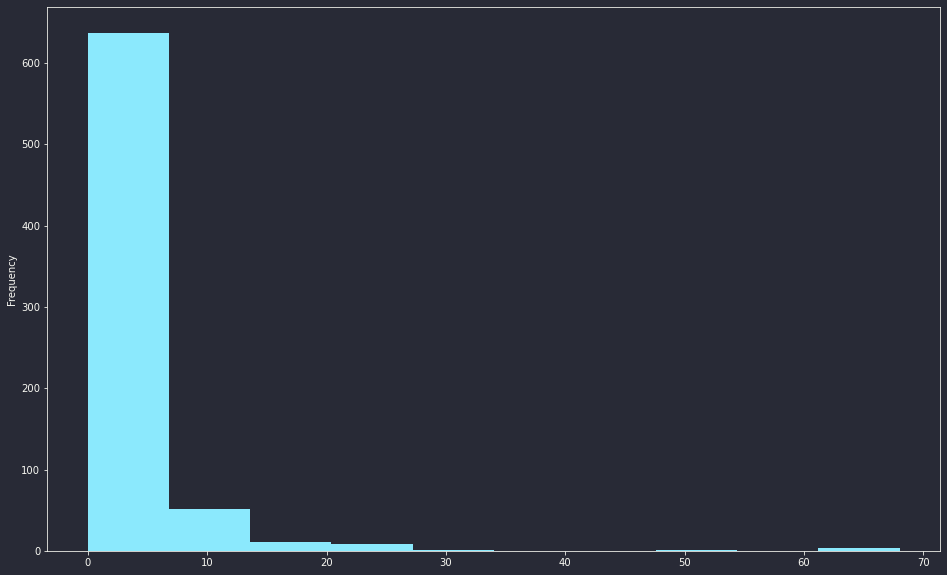

In [20]:
def ticker_nas(df):
    l = len(df)
    no_de = df["debt_mkt_cap"].isna().sum()
    no_ro = df["roi"].isna().sum()
    no_ey = df["price_earnings"].isna().sum()
    return pd.Series([l, no_de, no_ro, no_ey], index=["length", "no_de", "no_ro", "no_ey"])

eodz = eodz[eodz["date"]>="2014-03-01"].sort_values(["date", "ticker"]).reset_index(drop=True)
eodz.groupby("ticker").apply(ticker_nas)["no_de"].plot.hist()
plt.title("Frequency of NaN values: vast majority have no NaNs")
plt.show()

In [21]:
cols = ["ticker", "date", "debt_mkt_cap", "roi", "earnings_yield"]

center_of_mass = 5
ewm_ind = eodz[cols].groupby("ticker").ewm(com=center_of_mass).mean()

signal_cols = ["sig_de", "sig_roi", "sig_ey"]
eodz[signal_cols] = ewm_ind.reset_index(level=0, drop=True).sort_index()

In [22]:
def quantile_assignment(df, field):
    """Assigns quantiles to each field
    Fills NaN values as 5 to not interfere with trading logic."""
    df[f"q_{field}"] = pd.qcut(df[field], 10, labels=False).fillna(5)
    return df

eodz = eodz.groupby("date").apply(quantile_assignment, field="sig_de")
eodz = eodz.groupby("date").apply(quantile_assignment, field="sig_roi")
eodz = eodz.groupby("date").apply(quantile_assignment, field="sig_ey")

In [23]:
eodz_cols = ["date", "ticker", "adj_close", "q_sig_de", "q_sig_roi", "q_sig_ey"]

trading_df = eodz[eodz_cols].copy(deep=True)
gc_rate = (rates["gc"] / 52).rolling(30).mean().to_frame().reset_index().rename(columns={"Date": "date"})
trading_df = trading_df.merge(gc_rate, on="date")
trading_df.set_index("date", inplace=True)

trading_df = trading_df.groupby("ticker").resample("W-Fri", label="right").last()
trading_df = trading_df.reset_index(level=0, drop=True)
trading_df.sort_index(inplace=True)

In [24]:
((trading_df["q_sig_roi"] + trading_df["q_sig_ey"]) > 16).sum() / len(trading_df)

0.06217858812529219

In [25]:
trading_df

,ticker,adj_close,q_sig_de,q_sig_roi,q_sig_ey,gc
date,,,,,,
2014-03-07,AAP,122.6084,4.0000,5.0000,2.0000,-0.0001
2014-03-07,GEL,29.5583,7.0000,2.0000,2.0000,-0.0001
2014-03-07,ACCO,5.4243,8.0000,8.0000,9.0000,-0.0001
2014-03-07,OTTR,23.4867,5.0000,3.0000,6.0000,-0.0001
2014-03-07,FISV,29.3900,7.0000,7.0000,5.0000,-0.0001
...,...,...,...,...,...,...
2021-01-01,SREV,1.7600,0.0000,0.0000,1.0000,-0.0001
2021-01-01,CLH,76.1000,5.0000,5.0000,6.0000,-0.0001
2021-01-01,STX,60.2356,8.0000,8.0000,6.0000,-0.0001
